In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#Multiclass classification
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [3]:
num_features = 2
num_classes = 4

In [4]:
X_blob,y_blob = make_blobs(n_samples = 1000,n_features=num_features,centers=num_classes,cluster_std=1.5,random_state=42)

In [5]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=42)

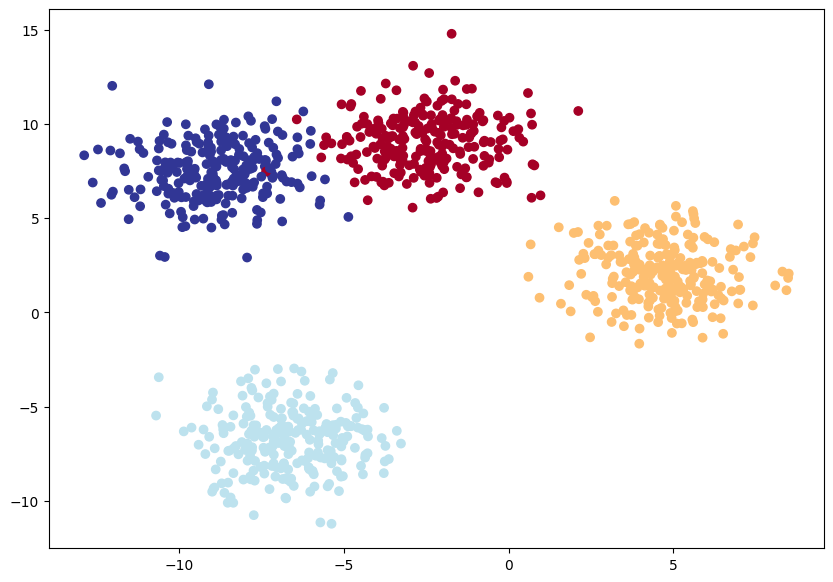

In [7]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
class MultiClassify(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    def forward(self,x):
        return self.layer(x)

In [10]:
model0 = MultiClassify(2,4).to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.05
optimizer = torch.optim.Adam(params=model0.parameters(),lr = lr)

In [12]:
epochs = 100
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model0.train()
    y_logits = model0(X_train)
    # print(y_logits.shape)
    y_softmax = torch.softmax(y_logits,dim=1)
    # print(y_softmax.shape)
    loss = loss_fn(y_logits,y_train.long())
    y_pred = torch.argmax(y_softmax,dim=1)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model0.eval()
    with torch.inference_mode():
        y_pred = model0(X_test)
        loss = loss_fn(y_pred,y_test.long())
        print(loss)

tensor(1.3344, device='cuda:0')
tensor(1.2281, device='cuda:0')
tensor(1.1156, device='cuda:0')
tensor(0.9861, device='cuda:0')
tensor(0.8762, device='cuda:0')
tensor(0.8069, device='cuda:0')
tensor(0.7211, device='cuda:0')
tensor(0.6312, device='cuda:0')
tensor(0.5162, device='cuda:0')
tensor(0.4196, device='cuda:0')
tensor(0.3432, device='cuda:0')
tensor(0.2440, device='cuda:0')
tensor(0.1811, device='cuda:0')
tensor(0.1262, device='cuda:0')
tensor(0.1004, device='cuda:0')
tensor(0.0774, device='cuda:0')
tensor(0.0438, device='cuda:0')
tensor(0.0233, device='cuda:0')
tensor(0.0159, device='cuda:0')
tensor(0.0115, device='cuda:0')
tensor(0.0146, device='cuda:0')
tensor(0.0260, device='cuda:0')
tensor(0.0253, device='cuda:0')
tensor(0.0129, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0.0076, device='cuda:0')
tensor(0.0155, device='cuda:0')
tensor(0.0243, device='cuda:0')
tensor(0.0170, device='cuda:0')
tensor(0.0080, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0

In [13]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    X_to_pred_on = X_to_pred_on

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

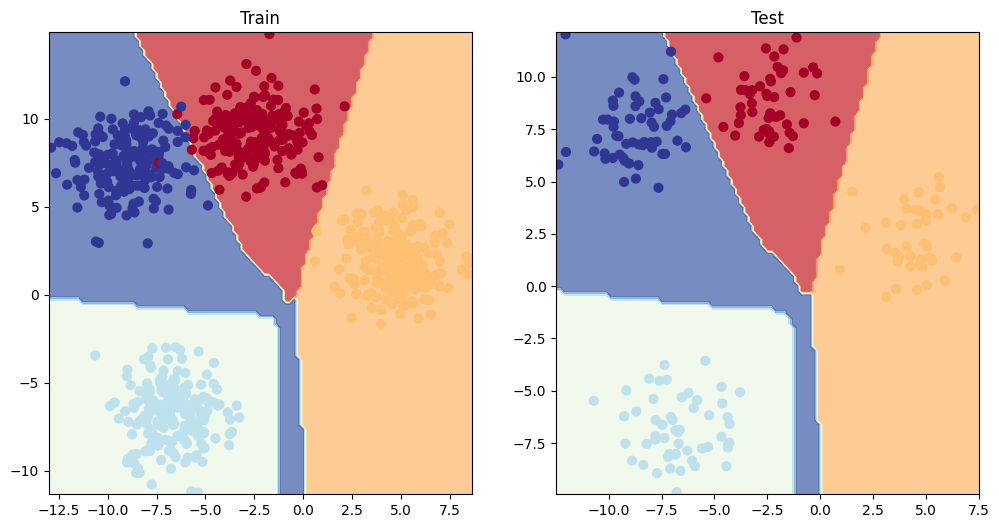

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0,X_test,y_test)

In [29]:
from torchmetrics import Accuracy
num_classes = [0,1,2,3]
acc = Accuracy(task='multiclass',num_classes=4).to(device)
acc(torch.argmax(y_pred,dim=1),y_test)

tensor(1., device='cuda:0')